# The Facebook Prophet Model

## Table of Contents

1. [Import Libraries](#Import_Libraries)
2. [Setup MLFlow Tracking](#MLFlow_Tracking)
3. [Load Data](#Load_Data)
4. [Pre-Process Data](#Pre_Processing)


5. Product Categories
   
   5.1 [Bed, Bath and Table](#bed_bath_table) 
   
   5.2 [Health and Beauty](#health_beauty)
   
   5.3 [Sports and Leisure](#sports_leisure)
   
   5.4 [Furniture Decor](#furniture_decor)
   
   5.5 [Watches and Gifts](#watches_gifts)
   
   5.6 [Telephony](#telephony)
   
   5.7 [Housewares](#housewares)

# Import Libraries <a name = "Import_Libraries"/>

In [1]:
import sys
import os
from utils import utils, metrics, dataset_2
import json
from pprint import pprint
import re
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from fbprophet import Prophet
#Plotting interactive figures for Prophet forecasts can be created using plotly. 
#Plotly needs to be installed separately becuase it is not included with fbprophet installation.
from fbprophet.plot import plot_plotly
import plotly.offline as py
py.init_notebook_mode()
plt.style.use('bmh')
%matplotlib inline  
import seaborn as sns
import datetime
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score, median_absolute_error
from math import sqrt
#Track Params, Metrics & Results
import mlflow

C:\Users\feras\Anaconda3\lib\site-packages\nbformat\notebooknode.py:4: DeprecationWarning:

Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working



C:\Users\feras\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



# Setup MLFlow Tracking <a name = "MLFlow_Tracking"/>

https://www.mlflow.org/docs/latest/tracking.html

In [2]:
# If this is the first time running the notebook, uncomment next line.
#This is to create a file called mlruns which will store the logs for each time the notebook is run

#mlflow_experiment_id = mlflow.create_experiment('Olist_FB-Prophet_MLFlow')

#else:
mlflow.set_experiment('Olist_FB-Prophet_MLFlow')
client = mlflow.tracking.MlflowClient()
# See ui 
#!mlflow ui

# Load Data <a name = "Load_Data"/>

In [3]:
# Read Config file
config = "configs_Baselines.json"

try:
    with open(config, "r") as f:
        config = json.load(f)
        print('\033[92m','Load successfull. config = \n')
        pprint(config)
except:
    raise IOError(f"Impossible to read config file: {config}")

 Load successfull. config = 

{'dates': {'test_end': '2017-12-14',
           'test_start': '2017-12-01',
           'train_start': '2017-07-01',
           'valid_start': False},
 'directories': {'base_dir': 'brazilian-ecommerce'},
 'drop_date': False,
 'end_date': '2017-12-31 23:59:59',
 'pre_processing': {'add_date_features': False,
                    'col_name': 'payment_value',
                    'impute_nan': 'zero',
                    'prefix_name': 'lag',
                    'r_list': [0],
                    'rolling_history': False,
                    'window_size': 0},
 'product_categories': ['bed_bath_table',
                        'health_beauty',
                        'sports_leisure',
                        'furniture_decor',
                        'computer_accessories',
                        'housewares',
                        'watches_gifts',
                        'telephony',
                        'garden_tools',
                        'auto'],
 'rm

# Pre-Process Training and Test Datasets <a name = "Pre_Processing"/>

In [4]:
df_train, df_test = dataset_2.make_dataset(config)

# Product Category 1: Bed, Bath and Table <a name = "bed_bath_table"/>

In [5]:
#Filter on product category for train/test sets
bed_bath_table_train = df_train.loc[df_train['product_category_name'] == 'bed_bath_table']
bed_bath_table_test = df_test.loc[df_test['product_category_name'] == 'bed_bath_table']

#convert data dataframe for Facebook Prophet Use. Remove product cateogry column on filtered sets

bed_bath_table_train = bed_bath_table_train.rename(columns={'order_approved_at': 'ds', 'payment_value': 'y'})
bed_bath_table_train.drop(['product_category_name'], axis=1, inplace = True)

bed_bath_table_test = bed_bath_table_test.rename(columns={'order_approved_at': 'ds', 'payment_value': 'y'})
bed_bath_table_test.drop(['product_category_name'], axis=1, inplace = True)

#bed_bath_table_train_3.set_index('ds', inplace=True)
#bed_bath_table_test

## Train & Fit Prophet Model 

In [6]:
#Instantiate a new Prophet object that represents the model
#The interval_width parameter sets the uncertainty interval used by the model. Default is 80%.

bed_bath_table_model = Prophet(interval_width=0.80)

#Call the built-in holiday collection for Brazil to be included in the model
bed_bath_table_model.add_country_holidays(country_name='BR')

# Fit the FB Prohpet Model
bed_bath_table_model.fit(bed_bath_table_train)

#Make future forecasts/predictions
#To be able to generate forecasts 'yhat' Prophet exepcts a dataframe that contains 
#the dates for which forecasts/predictions are made. The make_future_dataframe function does just that:
future_dates = bed_bath_table_model.make_future_dataframe(periods=13)
#future_dates.head(5)

INFO:numexpr.utils:NumExpr defaulting to 4 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [7]:
bed_bath_table_model.train_holiday_names

0                New Year's Day
1                    Tiradentes
2                  Worker's Day
3              Independence Day
4    Our Lady of the Apparition
5                All Souls' Day
6     Republic Proclamation Day
7                     Christmas
dtype: object

In [7]:
forecast = bed_bath_table_model.predict(future_dates[-13:])
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds        yhat  yhat_lower   yhat_upper
8  2017-12-09  550.898155   36.476584  1116.966711
9  2017-12-10  277.913841 -254.356085   790.579504
10 2017-12-11  348.904562 -150.030694   862.397792
11 2017-12-12  690.485302  207.693712  1196.073162
12 2017-12-13  475.869880  -76.496080  1033.866331

## Plot Results

In [8]:
fig = plot_plotly(bed_bath_table_model, forecast,uncertainty=True)#Returns an interactive plotly figure (Practical & User Friendly!)
py.iplot(fig)


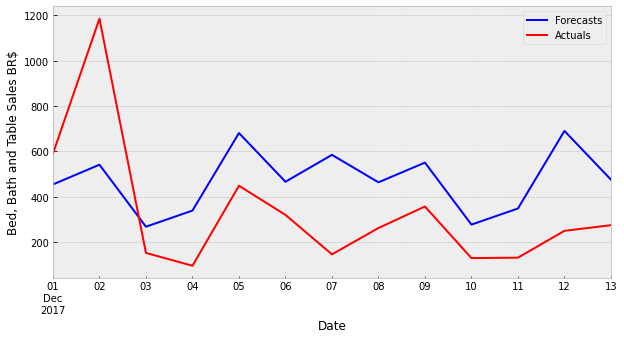

In [9]:
#Actuals vs. forecasts

forecasts_bbt  = np.maximum(forecast['yhat'],0)
forecasts_bbt.index =bed_bath_table_test['ds'].values
actuals = df_test.loc[df_test['product_category_name'] == 'bed_bath_table']
actuals = actuals.set_index('order_approved_at')

ax = forecasts_bbt.plot(color='blue', grid=True, label='Forecasts',figsize=(10, 5)) 

actuals['payment_value'].plot(ax=ax, color = 'red', label = 'Actuals')

ax.set_xlabel('Date')
ax.set_ylabel('Bed, Bath and Table Sales BR$')
plt.legend()
plt.show()

## Evaluate Performance

In [10]:
with mlflow.start_run() as run:                            
    mlflow.log_param('Product Category','Bed, Bath and Table')
    current_run_id = run.info.run_id        # -> Set the run id to a variable that can be used throughout the notebook
    print(f'Current run id: {current_run_id}')

Current run id: 24a2c4773f894210964b7c2c4fcd90f6


In [11]:
metrics.get_metrics(bed_bath_table_test.y, forecast['yhat'], run_id = current_run_id, log = True, param_prefix='test')


wape: 72472.01143156161
rms: 297.70500827431215
r2: -0.12366564008483127
mape: 1.1127538146229645


## Plot FB Prophet Model Components 

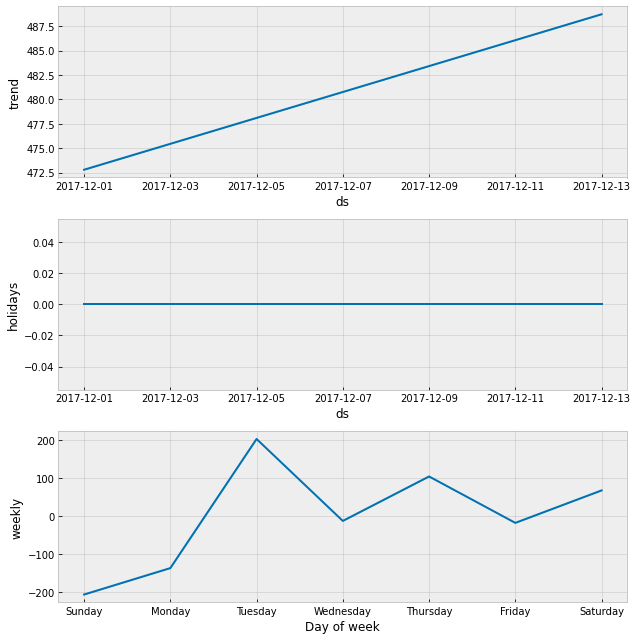

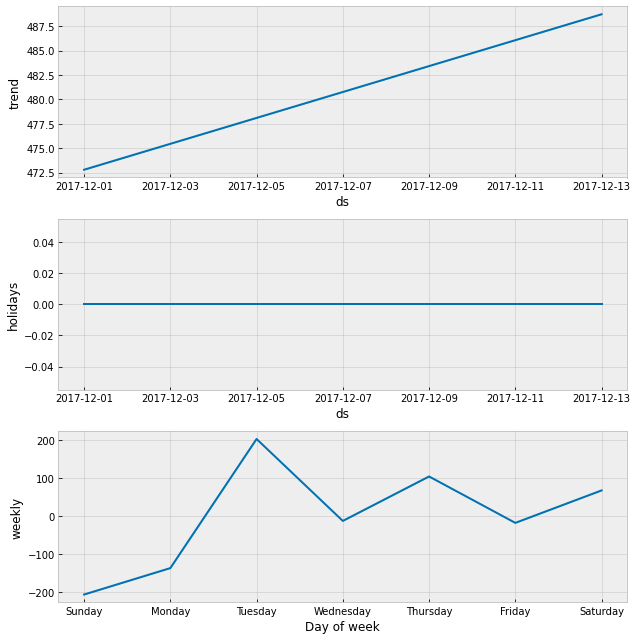

In [12]:
bed_bath_table_model.plot_components(forecast)

# Product Category 2: Heath & Beauty <a name = "health_beauty"/>

In [13]:
#Filter on product category for train/test sets
health_beauty_train = df_train.loc[df_train['product_category_name'] == 'health_beauty']
health_beauty_test = df_test.loc[df_test['product_category_name'] == 'health_beauty']

#convert data dataframe for Facebook Prophet Use. Remove product cateogry column on filtered sets

health_beauty_train = health_beauty_train.rename(columns={'order_approved_at': 'ds', 'payment_value': 'y'})
health_beauty_train.drop(['product_category_name'], axis=1, inplace = True)

health_beauty_test = health_beauty_test.rename(columns={'order_approved_at': 'ds', 'payment_value': 'y'})
health_beauty_test.drop(['product_category_name'], axis=1, inplace = True)

#health_beauty_test

## Train & Fit Prophet Model 

In [14]:
#Instantiate a new Prophet object that represents the model
#The interval_width parameter sets the uncertainty interval used by the model. Default is 80%.

health_beauty_model = Prophet(interval_width=0.80)

#Call the built-in holiday collection for Brazil to be included in the model
health_beauty_model.add_country_holidays(country_name='BR')

# Fit the FB Prohpet Model
health_beauty_model.fit(health_beauty_train)

#Make future forecasts/predictions
#To be able to generate forecasts 'yhat' Prophet exepcts a dataframe that contains 
#the dates for which forecasts/predictions are made. The make_future_dataframe function does just that:
future_dates = health_beauty_model.make_future_dataframe(periods=13)
#future_dates.head(5)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [15]:
forecast = health_beauty_model.predict(future_dates[-13:])
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds        yhat  yhat_lower   yhat_upper
8  2017-12-09  374.546206 -178.313336   932.136364
9  2017-12-10  327.476284 -222.618215   894.983593
10 2017-12-11  510.737075  -96.848691  1108.221699
11 2017-12-12  749.196976  162.582157  1306.706462
12 2017-12-13  383.584548 -221.177707   932.088294

## Plot Results

In [16]:
fig = plot_plotly(health_beauty_model, forecast,uncertainty=True)#Returns an interactive plotly figure (Practical & User Friendly!)
py.iplot(fig)


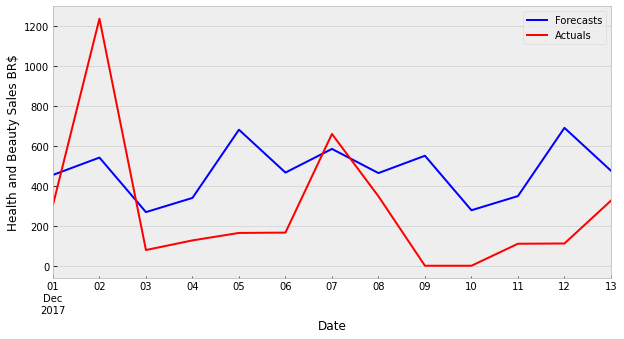

In [17]:
#Actuals vs. forecasts

forecasts_hb  = np.maximum(forecast['yhat'],0)
forecasts_hb.index =bed_bath_table_test['ds'].values
actuals = df_test.loc[df_test['product_category_name'] == 'health_beauty']
actuals = actuals.set_index('order_approved_at')

ax = forecasts_bbt.plot(color='blue', grid=True, label='Forecasts',figsize=(10, 5)) 

actuals['payment_value'].plot(ax=ax, color = 'red', label = 'Actuals')

ax.set_xlabel('Date')
ax.set_ylabel('Health and Beauty Sales BR$')
plt.legend()
plt.show()

## Evaluate Performance

In [18]:
with mlflow.start_run() as run:                            
    mlflow.log_param('Product Category','Health and Beauty')
    current_run_id = run.info.run_id        # -> Set the run id to a variable that can be used throughout the notebook
    print(f'Current run id: {current_run_id}')

Current run id: 2d56856130f249e6867480076bf189a1


In [19]:
metrics.get_metrics(health_beauty_test.y, forecast['yhat'], run_id = current_run_id, log = True, param_prefix='test')

wape: 91492.75378617269
rms: 409.342010964335
r2: -0.5871294683103612
mape: 55.61980477087873


## Plot FB Prophet Model Components

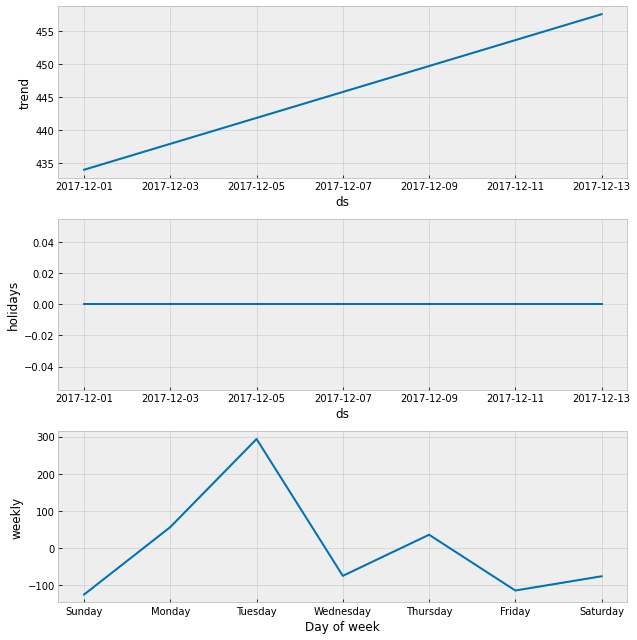

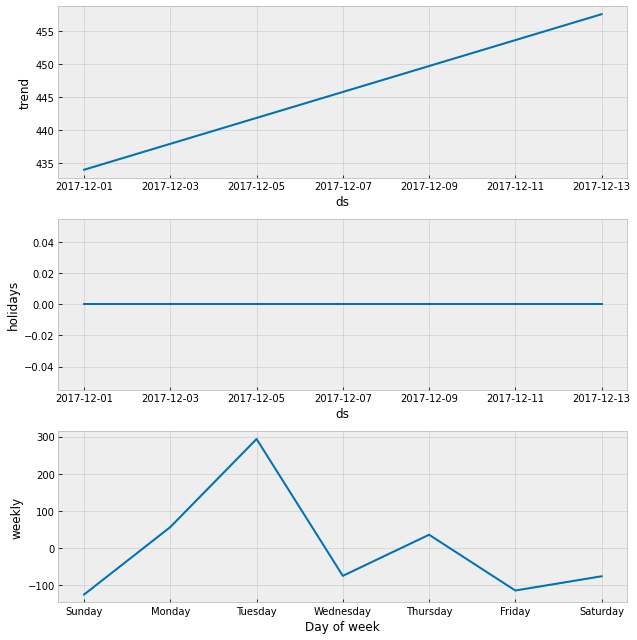

In [20]:
health_beauty_model.plot_components(forecast)

# Product Category 3: Sports and Leisure <a name = "sports_leisure"/>

In [21]:
#Filter on product category for train/test sets
sports_leisure_train = df_train.loc[df_train['product_category_name'] == 'sports_leisure']
sports_leisure_test = df_test.loc[df_test['product_category_name'] == 'sports_leisure']

#convert data dataframe for Facebook Prophet Use. Remove product cateogry column on filtered sets

sports_leisure_train = sports_leisure_train.rename(columns={'order_approved_at': 'ds', 'payment_value': 'y'})
sports_leisure_train.drop(['product_category_name'], axis=1, inplace = True)

sports_leisure_test = sports_leisure_test.rename(columns={'order_approved_at': 'ds', 'payment_value': 'y'})
sports_leisure_test.drop(['product_category_name'], axis=1, inplace = True)

#sports_leisure_test

## Train & Fit Prophet Model 

In [22]:
#Instantiate a new Prophet object that represents the model
#The interval_width parameter sets the uncertainty interval used by the model. Default is 80%.

sports_leisure_model = Prophet(interval_width=0.80)

#Call the built-in holiday collection for Brazil to be included in the model
sports_leisure_model.add_country_holidays(country_name='BR')

# Fit the FB Prohpet Model
sports_leisure_model.fit(sports_leisure_train)

#Make future forecasts/predictions
#To be able to generate forecasts 'yhat' Prophet exepcts a dataframe that contains 
#the dates for which forecasts/predictions are made. The make_future_dataframe function does just that:
future_dates = sports_leisure_model.make_future_dataframe(periods=13)
#future_dates.head(5)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [23]:
forecast = sports_leisure_model.predict(future_dates[-13:])
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds        yhat  yhat_lower  yhat_upper
8  2017-12-09  560.780250  186.995672  895.557559
9  2017-12-10  358.193232   12.537345  689.002839
10 2017-12-11  400.420274   42.803981  738.311675
11 2017-12-12  644.632334  293.208337  999.667746
12 2017-12-13  607.202599  284.449237  961.602896

## Plot Results

In [24]:
fig = plot_plotly(sports_leisure_model, forecast,uncertainty=True)#Returns an interactive plotly figure (Practical & User Friendly!)
py.iplot(fig)


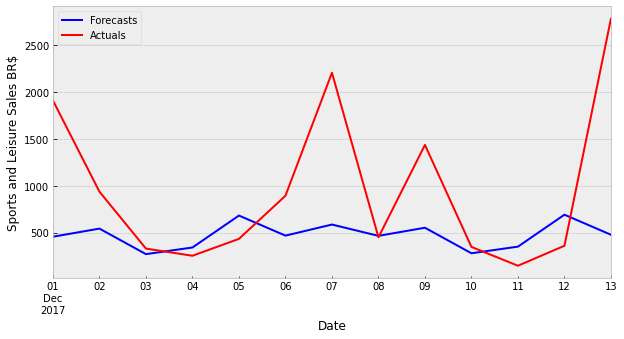

In [25]:
#Actuals vs. forecasts

forecasts_sl  = np.maximum(forecast['yhat'],0)
forecasts_sl.index =bed_bath_table_test['ds'].values
actuals = df_test.loc[df_test['product_category_name'] == 'sports_leisure']
actuals = actuals.set_index('order_approved_at')

ax = forecasts_bbt.plot(color='blue', grid=True, label='Forecasts',figsize=(10, 5)) 

actuals['payment_value'].plot(ax=ax, color = 'red', label = 'Actuals')

ax.set_xlabel('Date')
ax.set_ylabel('Sports and Leisure Sales BR$')
plt.legend()
plt.show()

## Evaluate Performance

In [26]:
with mlflow.start_run() as run:                            
    mlflow.log_param('Product Category','Sports and Leisure')
    current_run_id = run.info.run_id        # -> Set the run id to a variable that can be used throughout the notebook
    print(f'Current run id: {current_run_id}')

Current run id: 3c901f69ef38469a9a0f6a70e9a2a684


In [27]:
metrics.get_metrics(sports_leisure_test.y, forecast['yhat'], run_id = current_run_id, log = True, param_prefix='test')

wape: 901359.662332362
rms: 906.4359115997673
r2: -0.20252439635860164
mape: 0.574401773076226


## Plot FB Prophet Model Components

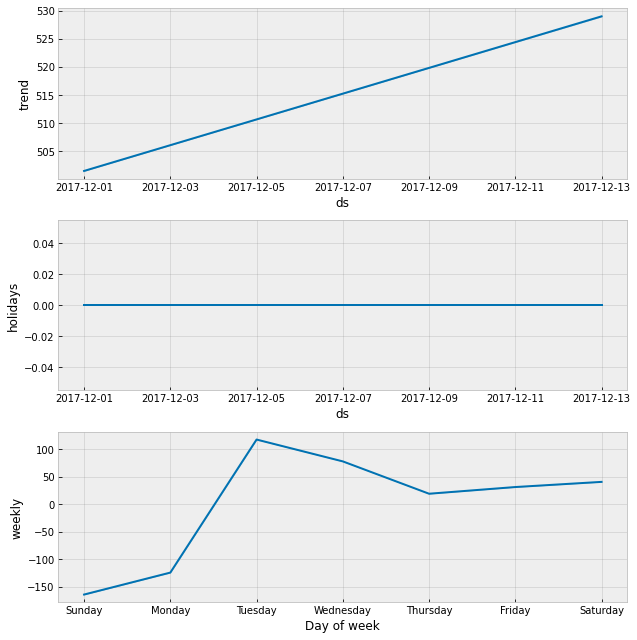

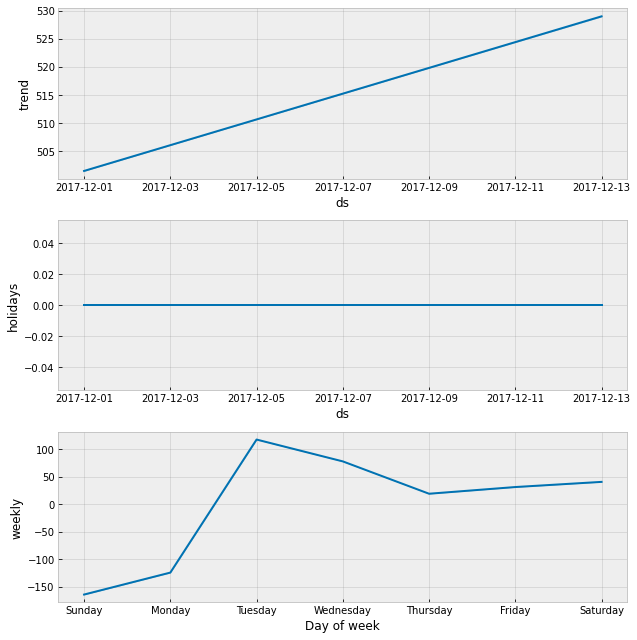

In [28]:
sports_leisure_model.plot_components(forecast)

# Product Category 4: Furniture Decor <a name = "furniture_decor"/>

In [29]:
#Filter on product category for train/test sets
furniture_decor_train = df_train.loc[df_train['product_category_name'] == 'furniture_decor']
furniture_decor_test = df_test.loc[df_test['product_category_name'] == 'furniture_decor']

#convert data dataframe for Facebook Prophet Use. Remove product cateogry column on filtered sets

furniture_decor_train = furniture_decor_train.rename(columns={'order_approved_at': 'ds', 'payment_value': 'y'})
furniture_decor_train.drop(['product_category_name'], axis=1, inplace = True)

furniture_decor_test = furniture_decor_test.rename(columns={'order_approved_at': 'ds', 'payment_value': 'y'})
furniture_decor_test.drop(['product_category_name'], axis=1, inplace = True)

## Train & Fit Prophet Model 

In [30]:
#Instantiate a new Prophet object that represents the model
#The interval_width parameter sets the uncertainty interval used by the model. Default is 80%.

furniture_decor_model = Prophet(interval_width=0.80)

#Call the built-in holiday collection for Brazil to be included in the model
furniture_decor_model.add_country_holidays(country_name='BR')

# Fit the FB Prohpet Model
furniture_decor_model.fit(furniture_decor_train)

#Make future forecasts/predictions
#To be able to generate forecasts 'yhat' Prophet exepcts a dataframe that contains 
#the dates for which forecasts/predictions are made. The make_future_dataframe function does just that:
future_dates = furniture_decor_model.make_future_dataframe(periods=13)
#future_dates.head(5)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [31]:
forecast = furniture_decor_model.predict(future_dates[-13:])
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds        yhat  yhat_lower   yhat_upper
8  2017-12-09  604.021932 -114.076889  1353.196528
9  2017-12-10  380.667637 -344.984976  1056.041672
10 2017-12-11  377.782264 -330.112312  1084.989465
11 2017-12-12  877.660366  133.531240  1650.489054
12 2017-12-13  694.619986  -12.215269  1427.302285

## Plot Results

In [32]:
fig = plot_plotly(furniture_decor_model, forecast,uncertainty=True)#Returns an interactive plotly figure (Practical & User Friendly!)
py.iplot(fig)


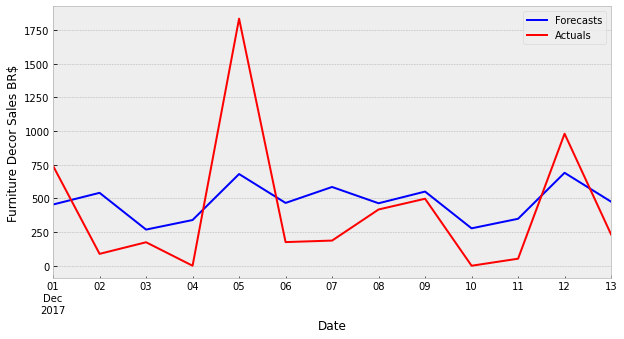

In [33]:
#Actuals vs. forecasts

forecasts_fd  = np.maximum(forecast['yhat'],0)
forecasts_fd.index =bed_bath_table_test['ds'].values
actuals = df_test.loc[df_test['product_category_name'] == 'furniture_decor']
actuals = actuals.set_index('order_approved_at')

ax = forecasts_bbt.plot(color='blue', grid=True, label='Forecasts',figsize=(10, 5)) 

actuals['payment_value'].plot(ax=ax, color = 'red', label = 'Actuals')

ax.set_xlabel('Date')
ax.set_ylabel('Furniture Decor Sales BR$')
plt.legend()
plt.show()

## Evaluate Performance

In [34]:
with mlflow.start_run() as run:                            
    mlflow.log_param('Product Category','Furniture Decor')
    current_run_id = run.info.run_id        # -> Set the run id to a variable that can be used throughout the notebook
    print(f'Current run id: {current_run_id}')

Current run id: ff0769ffa81747c1bd490d599fcf1e4a


In [35]:
metrics.get_metrics(furniture_decor_test.y, forecast['yhat'], run_id = current_run_id, log = True, param_prefix='test')

wape: 149289.854189058
rms: 423.8009465272931
r2: 0.27800447056130806
mape: 58.47873322657961


## Plot FB Prophet Model Components

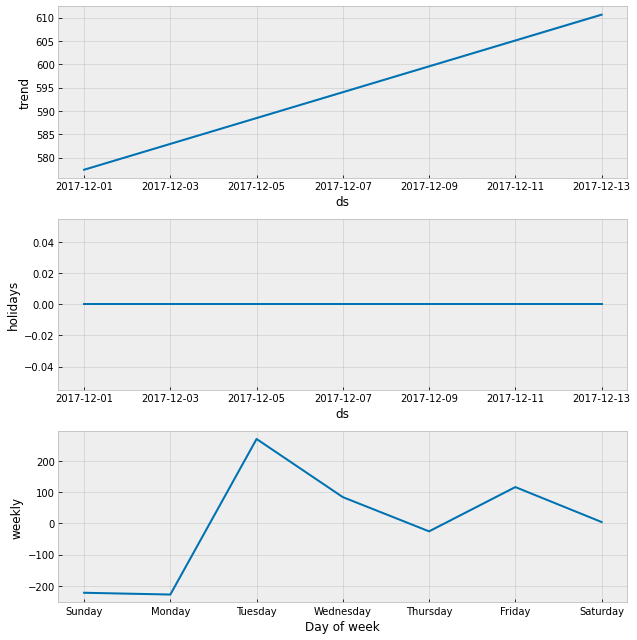

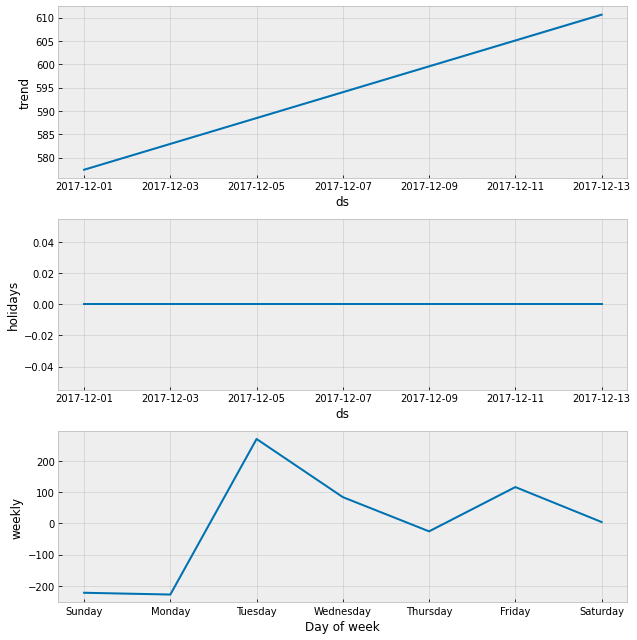

In [36]:
furniture_decor_model.plot_components(forecast)

# Product Category 5: Watches Gifts <a name = "watches_gifts"/>

In [37]:
#Filter on product category for train/test sets
watches_gifts_train = df_train.loc[df_train['product_category_name'] == 'watches_gifts']
watches_gifts_test = df_test.loc[df_test['product_category_name'] == 'watches_gifts']

#convert data dataframe for Facebook Prophet Use. Remove product cateogry column on filtered sets

watches_gifts_train = watches_gifts_train.rename(columns={'order_approved_at': 'ds', 'payment_value': 'y'})
watches_gifts_train.drop(['product_category_name'], axis=1, inplace = True)

watches_gifts_test = watches_gifts_test.rename(columns={'order_approved_at': 'ds', 'payment_value': 'y'})
watches_gifts_test.drop(['product_category_name'], axis=1, inplace = True)
#watches_gifts_test

## Train & Fit Prophet Model

In [38]:
#Instantiate a new Prophet object that represents the model
#The interval_width parameter sets the uncertainty interval used by the model. Default is 80%.

watches_gifts_model = Prophet(interval_width=0.80)

#Call the built-in holiday collection for Brazil to be included in the model
watches_gifts_model.add_country_holidays(country_name='BR')

# Fit the FB Prohpet Model
watches_gifts_model.fit(watches_gifts_train)

#Make future forecasts/predictions
#To be able to generate forecasts 'yhat' Prophet exepcts a dataframe that contains 
#the dates for which forecasts/predictions are made. The make_future_dataframe function does just that:
future_dates = watches_gifts_model.make_future_dataframe(periods=13)
#future_dates.head(5)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [39]:
forecast = watches_gifts_model.predict(future_dates[-13:])
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds        yhat  yhat_lower   yhat_upper
8  2017-12-09  364.299603 -161.534521   886.424837
9  2017-12-10  561.768153   41.976610  1089.172339
10 2017-12-11  362.971142 -197.908069   839.724597
11 2017-12-12  466.461391 -101.357316  1024.681773
12 2017-12-13  478.358611  -38.906346   999.016400

## Plot Results

In [40]:
fig = plot_plotly(watches_gifts_model, forecast,uncertainty=True)#Returns an interactive plotly figure (Practical & User Friendly!)
py.iplot(fig)


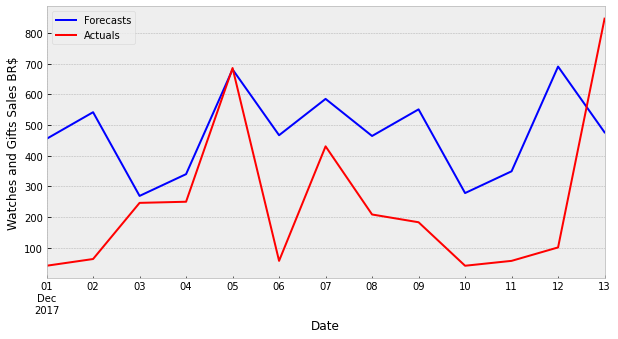

In [41]:
#Actuals vs. forecasts

forecasts_wg  = np.maximum(forecast['yhat'],0)
forecasts_wg.index =bed_bath_table_test['ds'].values
actuals = df_test.loc[df_test['product_category_name'] == 'watches_gifts']
actuals = actuals.set_index('order_approved_at')

ax = forecasts_bbt.plot(color='blue', grid=True, label='Forecasts',figsize=(10, 5)) 

actuals['payment_value'].plot(ax=ax, color = 'red', label = 'Actuals')

ax.set_xlabel('Date')
ax.set_ylabel('Watches and Gifts Sales BR$')
plt.legend()
plt.show()

## Evaluate Performance

In [42]:
with mlflow.start_run() as run:                            
    mlflow.log_param('Product Category','Watches and Gifts')
    current_run_id = run.info.run_id        # -> Set the run id to a variable that can be used throughout the notebook
    print(f'Current run id: {current_run_id}')

Current run id: 72ce757ea7c44a39b26561883a71ef1c


In [43]:
metrics.get_metrics(watches_gifts_test.y, forecast['yhat'], run_id = current_run_id, log = True, param_prefix='test')

wape: 39464.15447335727
rms: 297.51054120456143
r2: -0.43089217555683934
mape: 3.304743154862041


## Plot FB Prophet Model Components

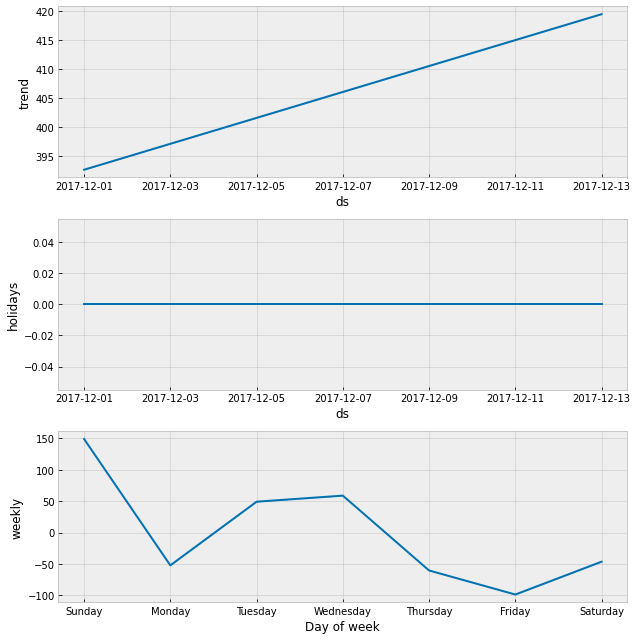

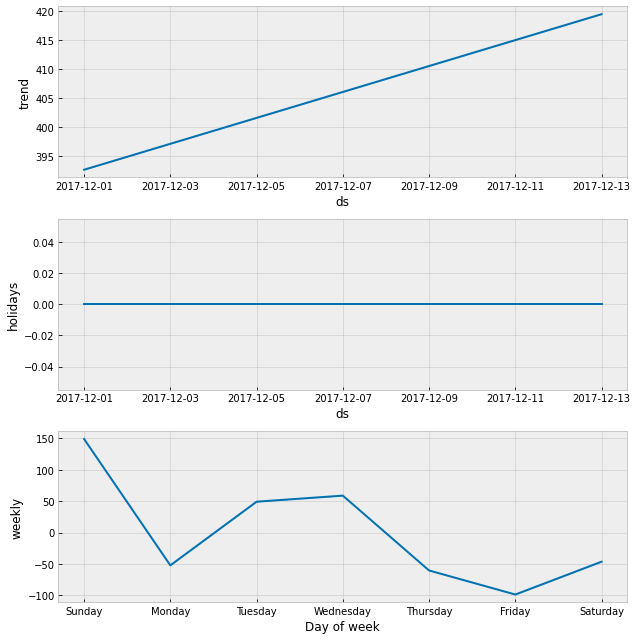

In [44]:
watches_gifts_model.plot_components(forecast)

# Product Category 6: Telephony <a name = "telephony"/>

In [45]:
#Filter on product category for train/test sets
telephony_train = df_train.loc[df_train['product_category_name'] == 'telephony']
telephony_test = df_test.loc[df_test['product_category_name'] == 'telephony']

#convert data dataframe for Facebook Prophet Use. Remove product cateogry column on filtered sets

telephony_train = telephony_train.rename(columns={'order_approved_at': 'ds', 'payment_value': 'y'})
telephony_train.drop(['product_category_name'], axis=1, inplace = True)

telephony_test = telephony_test.rename(columns={'order_approved_at': 'ds', 'payment_value': 'y'})
telephony_test.drop(['product_category_name'], axis=1, inplace = True)
#watches_gifts_test

## Train & Fit Prophet Model 

In [46]:
#Instantiate a new Prophet object that represents the model
#The interval_width parameter sets the uncertainty interval used by the model. Default is 80%.

telephony_model = Prophet(interval_width=0.80)

#Call the built-in holiday collection for Brazil to be included in the model
telephony_model.add_country_holidays(country_name='BR')

# Fit the FB Prohpet Model
telephony_model.fit(telephony_train)

#Make future forecasts/predictions
#To be able to generate forecasts 'yhat' Prophet exepcts a dataframe that contains 
#the dates for which forecasts/predictions are made. The make_future_dataframe function does just that:
future_dates = telephony_model.make_future_dataframe(periods=13)
#future_dates.head(5)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [47]:
forecast = telephony_model.predict(future_dates[-13:])
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds        yhat  yhat_lower  yhat_upper
8  2017-12-09  124.478995  -53.016089  322.827309
9  2017-12-10  113.103137  -69.676886  312.719620
10 2017-12-11  154.846296  -27.109636  351.070601
11 2017-12-12  254.866504   73.177109  442.073115
12 2017-12-13  129.407585  -43.259380  318.291944

## Plot Results

In [48]:
fig = plot_plotly(telephony_model, forecast,uncertainty=True)#Returns an interactive plotly figure (Practical & User Friendly!)
py.iplot(fig)


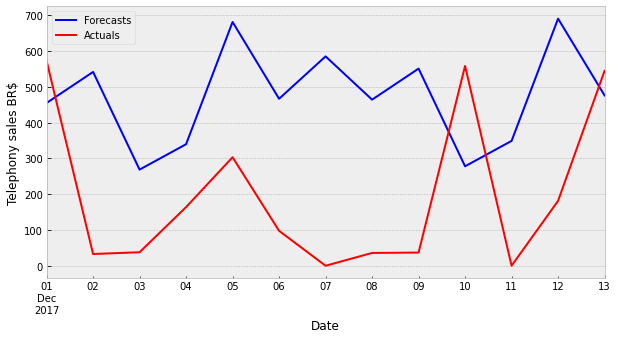

In [49]:
#Actuals vs. forecasts

forecasts_tl  = np.maximum(forecast['yhat'],0)
forecasts_tl.index =bed_bath_table_test['ds'].values
actuals = df_test.loc[df_test['product_category_name'] == 'telephony']
actuals = actuals.set_index('order_approved_at')

ax = forecasts_bbt.plot(color='blue', grid=True, label='Forecasts',figsize=(10, 5)) 

actuals['payment_value'].plot(ax=ax, color = 'red', label = 'Actuals')

ax.set_xlabel('Date')
ax.set_ylabel('Telephony sales BR$')
plt.legend()
plt.show()

## Evaluate Performance

In [50]:
with mlflow.start_run() as run:                            
    mlflow.log_param('Product Category','Telephony')
    current_run_id = run.info.run_id        # -> Set the run id to a variable that can be used throughout the notebook
    print(f'Current run id: {current_run_id}')

Current run id: 74058faec1194a32ad94e9dc10c19839


In [51]:
metrics.get_metrics(telephony_test.y, forecast['yhat'], run_id = current_run_id, log = True, param_prefix='test')

wape: 52845.427706094
rms: 217.9208907941965
r2: -0.03449469351923429
mape: 25.393533663715655


## Plot FB Model Components

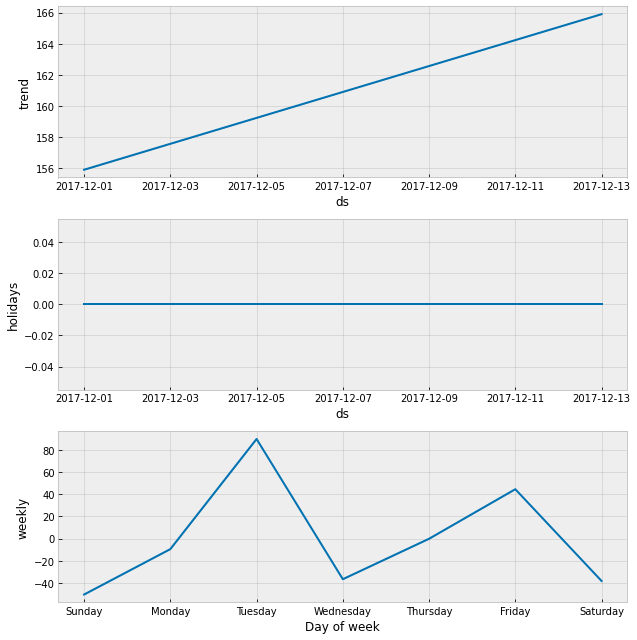

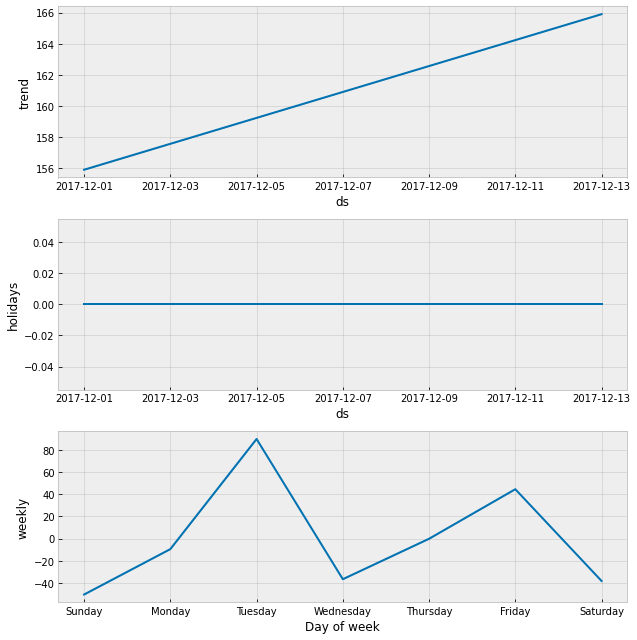

In [52]:
telephony_model.plot_components(forecast)

# Product Category 7: Housewares <a name = "housewares"/>

In [53]:
#Filter on product category for train/test sets
housewares_train = df_train.loc[df_train['product_category_name'] == 'housewares']
housewares_test = df_test.loc[df_test['product_category_name'] == 'housewares']

#convert data dataframe for Facebook Prophet Use. Remove product cateogry column on filtered sets

housewares_train = housewares_train.rename(columns={'order_approved_at': 'ds', 'payment_value': 'y'})
housewares_train.drop(['product_category_name'], axis=1, inplace = True)

housewares_test = housewares_test.rename(columns={'order_approved_at': 'ds', 'payment_value': 'y'})
housewares_test.drop(['product_category_name'], axis=1, inplace = True)
#watches_gifts_test

## Train & Fit Prophet Model

In [54]:
#Instantiate a new Prophet object that represents the model
#The interval_width parameter sets the uncertainty interval used by the model. Default is 80%.

housewares_model = Prophet(interval_width=0.80)

#Call the built-in holiday collection for Brazil to be included in the model
housewares_model.add_country_holidays(country_name='BR')

# Fit the FB Prohpet Model
housewares_model.fit(housewares_train)

#Make future forecasts/predictions
#To be able to generate forecasts 'yhat' Prophet exepcts a dataframe that contains 
#the dates for which forecasts/predictions are made. The make_future_dataframe function does just that:
future_dates = housewares_model.make_future_dataframe(periods=13)
#future_dates.head(5)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [55]:
forecast = housewares_model.predict(future_dates[-13:])
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds        yhat  yhat_lower  yhat_upper
8  2017-12-09  197.979748  -38.037329  454.691981
9  2017-12-10  145.472013 -100.830771  390.783559
10 2017-12-11  197.317278  -42.618015  470.351189
11 2017-12-12  398.460253  159.711069  653.514910
12 2017-12-13  295.102400   59.035595  529.313319

## Plot Results

In [56]:
fig = plot_plotly(housewares_model, forecast,uncertainty=True)#Returns an interactive plotly figure (Practical & User Friendly!)
py.iplot(fig)


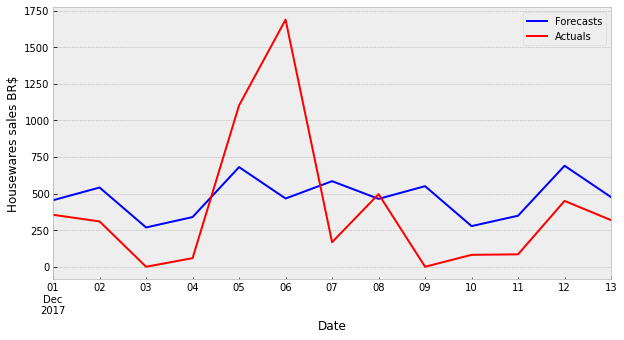

In [57]:
#Actuals vs. forecasts

forecasts_hw  = np.maximum(forecast['yhat'],0)
forecasts_hw.index =bed_bath_table_test['ds'].values
actuals = df_test.loc[df_test['product_category_name'] == 'housewares']
actuals = actuals.set_index('order_approved_at')

ax = forecasts_bbt.plot(color='blue', grid=True, label='Forecasts',figsize=(10, 5)) 

actuals['payment_value'].plot(ax=ax, color = 'red', label = 'Actuals')

ax.set_xlabel('Date')
ax.set_ylabel('Housewares sales BR$')
plt.legend()
plt.show()

## Evaluate Performance

In [58]:
with mlflow.start_run() as run:                            
    mlflow.log_param('Product Category','Housewares')
    current_run_id = run.info.run_id        # -> Set the run id to a variable that can be used throughout the notebook
    print(f'Current run id: {current_run_id}')

Current run id: 859d4c42f1b5499283dad99c3ed5e43d


In [59]:
metrics.get_metrics(housewares_test.y, forecast['yhat'], run_id = current_run_id, log = True, param_prefix='test')

wape: 226835.87954754935
rms: 455.46841832872406
r2: 0.0623719413386673
mape: 26.731209555121556


## Plot FB Prophet Model Components

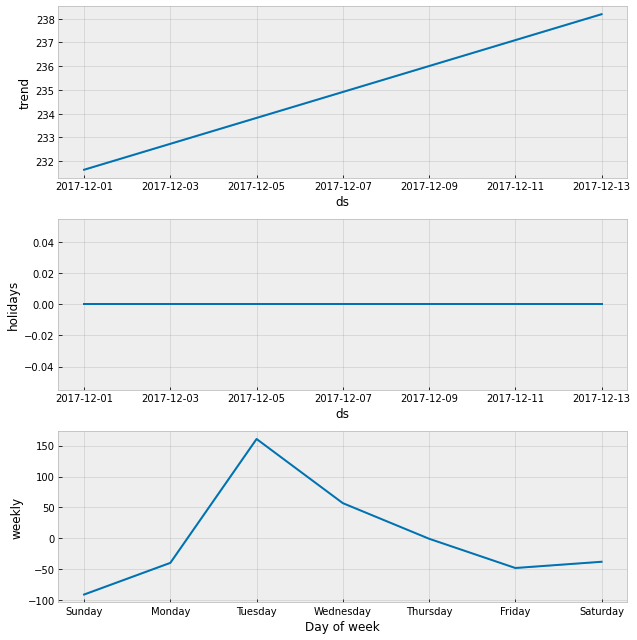

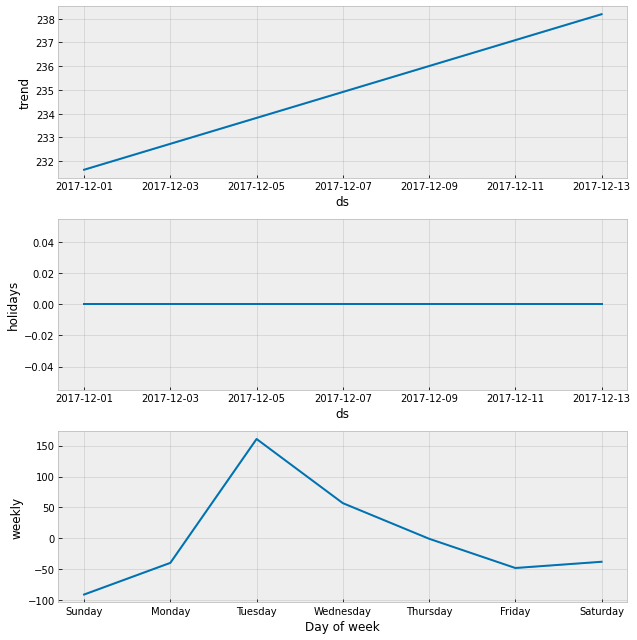

In [60]:
housewares_model.plot_components(forecast)